In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt 
from scipy import stats
from scipy import polyval
import matplotlib.pyplot as plt
from photutils import * 
from scipy.optimize import curve_fit
import pandas as pd

# --- Astronomy Related Packages --- 
from photutils import *
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
from scipy.stats import sigmaclip
Vizier.ROW_LIMIT = -1

In [2]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

# World Coordinate System Definition 

In [3]:
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'NGC2324_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

In [4]:
temp_file_name = 'astrometric_obs_data/NGC2324_B_wcs.fits'
filter_type = 'B'

# --- Loading Relevant Files and Header Parameters --- 
hdulist = fits.open(temp_file_name)
tWCS = wcs.WCS(hdulist[0].header) #global variable
image_data = hdulist[0].data; print(np.shape(image_data))

target_name = temp_file_name[21:-8]
print(target_name)

(800, 850)
NGC2324_B_


## DAO Starfinder

Slight modfication used in the main body of the data-analysis. Basically identical, re-defined here for ease of use. 

In [5]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg'); plt.show()

    return mst_sources

## WCS Conversion 

In [6]:
def WCS_conversion(file_path):
    '''
    INPUT - .fits image for reading the WCS from the header, DAO Sources from a given image
    FUNCTION - Uses (x and y) centroid positions and the wcs to convert pixel values into RA and DEC (J2000)
    OUTPUT - An array of WCS values for each source in the fits file. where [n][0] - RA and [n][1] - DEC. And RA, DEC for centre-frame. 
    '''

    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header) # Parse the WCS keywords in the primary HDU
    data = hdulist[0].data

    DAO_sources  = starfinder(data, 6, False) # calling the star finder function 
    target_RADEC = []

    for idx in range(0, len(DAO_sources)):
        world = w.pixel_to_world(DAO_sources['xcentroid'][idx], DAO_sources['ycentroid'][idx])
        target_RADEC.append(world)

    centre =  w.pixel_to_world(np.shape(data)[0]/2, np.shape(data)[1]/2)
    
    return target_RADEC, centre, DAO_sources

def Pixel_conversion(RA, DEC, file_path): 
    coords = SkyCoord(RA, DEC, unit = 'deg')
    
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.world_to_pixel(coords)

def single_WCS_conversion(x_pix, y_pix, file_path): 
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.pixel_to_world(x_pix, y_pix)


In [7]:
tar, cnt, DAO_source_table = WCS_conversion(temp_file_name)
edge = single_WCS_conversion(0, 0, temp_file_name)
sep = cnt.separation(edge).degree

In [8]:
if str(filter_type) == 'B': 
    filter_val = 'Bmag'
    filter_eval = 'e_Bmag'
else:
    filter_val = 'Bmag'
    filter_eval = 'e_Bmag'

print(filter_val, filter_eval)

Bmag e_Bmag


In [9]:
def APASS_query(frame_center):
    edge = tWCS.pixel_to_world(0, 0)
    query_radius = frame_center.separation(edge).degree # returns seperation in correct unit. 
    print(query_radius)

    return(Vizier.query_region(coord.SkyCoord(frame_center, frame='fk5'), radius=Angle(query_radius, "deg"),  catalog='apass9')[0])

edge = tWCS.pixel_to_world(0, 0); max_ed = tWCS.pixel_to_world(850, 800)

catalog_result = APASS_query(cnt)
thrs = catalog_result[filter_eval].mean() + catalog_result[filter_eval].std()
# catalog_result = (catalog_result[np.where(catalog_result['DEJ2000'] > edge.dec.degree) and np.where(catalog_result['DEJ2000'] < max_ed.dec.degree)])
# and catalog_result[np.where(catalog_result['RAJ2000'] > edge.ra.degree) and np.where(catalog_result['RAJ2000'] < max_ed.ra.degree)]])

catalog_result = catalog_result[np.where(catalog_result[filter_eval] < thrs) and np.where(catalog_result[filter_eval] > 0)]
test_RA = catalog_result['RAJ2000']
test_DEC = catalog_result['DEJ2000']

catalog_result

0.10148158741052861


recno,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag
,deg,deg,arcsec,arcsec,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float32,float32,int64,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
21947441,105.995965,0.955826,0.781,0.404,20140040,5,21,0.688,0.033,14.914,0.029,15.602,0.016,15.195,0.027,14.756,0.030,14.598,0.042
21947442,106.029437,0.951538,0.403,0.438,20110040,7,27,0.273,0.038,14.235,0.029,14.508,0.024,14.282,0.032,14.220,0.014,14.317,0.058
21947444,106.033922,0.963522,0.444,1.258,20140040,4,14,0.477,0.060,15.117,0.033,15.595,0.050,15.280,0.010,15.029,0.063,15.058,0.070
21947446,106.042052,0.948084,0.517,0.858,20140040,3,12,0.692,0.066,15.557,0.052,16.249,0.040,15.811,0.000,15.406,0.056,15.268,0.298
21947447,106.047499,0.963410,0.789,0.384,20140040,3,8,0.746,0.034,15.838,0.023,16.584,0.025,16.132,0.016,15.612,0.054,--,--
21947448,106.049458,0.955469,1.316,0.304,20140040,3,8,1.156,0.123,16.681,0.120,17.838,0.026,17.222,0.046,16.486,0.037,--,--
21947449,106.044951,0.969728,0.578,0.346,20110040,8,29,0.230,0.020,13.967,0.011,14.198,0.017,14.009,0.025,13.999,0.016,14.071,0.041
21947450,106.051196,0.975910,0.374,1.263,20110040,5,14,0.585,0.048,14.513,0.000,15.098,0.048,14.731,0.016,14.343,0.009,--,--


In [10]:
obs_index = []; cat_index = []

catalog_coord = SkyCoord(catalog_result['RAJ2000'], catalog_result['DEJ2000'], unit = 'deg')

obs_idx = 0; cat_idx = 0 
for obs_coord in tar:
    sep2tar = obs_coord.separation(catalog_coord).degree
    if sep2tar.min() < 2e-3:
        obs_index.append(obs_idx)
        cat_index.append(np.argmin(sep2tar))
    cat_idx += 1
    obs_idx += 1 

# complete removal of duplicates from the set 
# res = [idx for idx, val in enumerate(cat_index) if val in cat_index[:idx]]
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)
# res = np.array(res) - 1
# cat_index = np.delete(cat_index, res); obs_index = np.delete(obs_index, res)

print('Number of reference target that meet conditions:', len(cat_index))

catalog_RA_pixel, catalog_DEC_pixel = Pixel_conversion(catalog_result['RAJ2000'], catalog_result['DEJ2000'], temp_file_name)

Number of reference target that meet conditions: 158


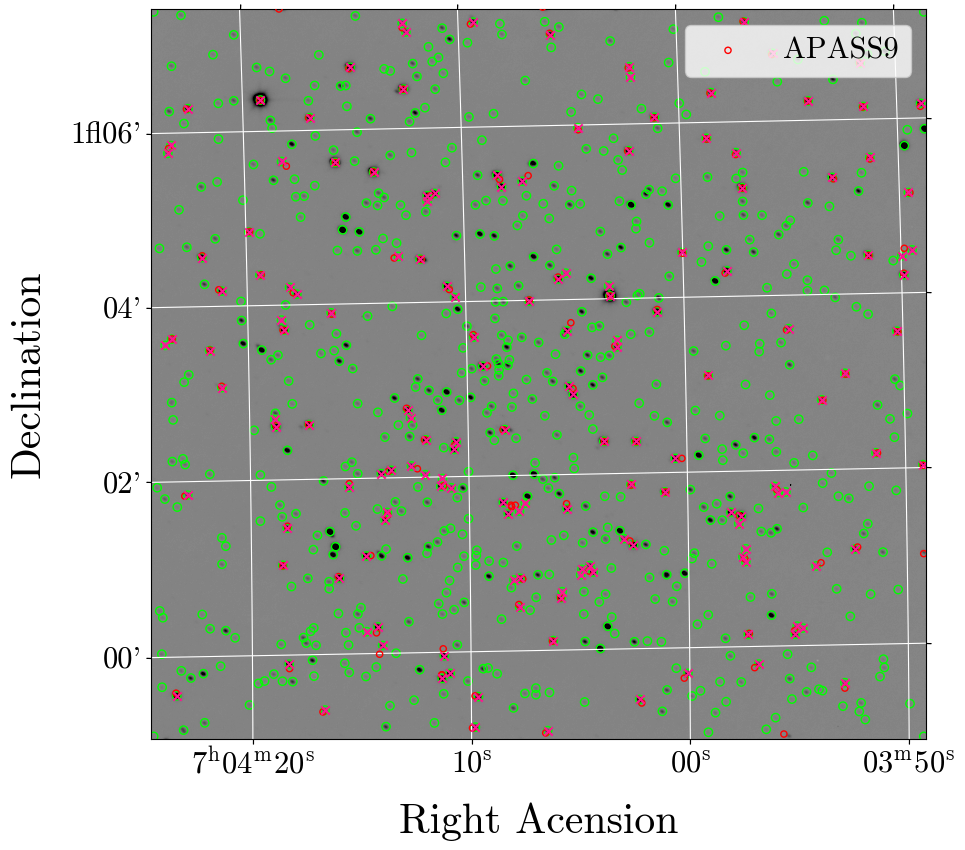

In [11]:
pixel_coords_total = []

for idx in range(0, len(test_RA)): 
    pixel_coords = Pixel_conversion(test_RA[idx], test_DEC[idx], temp_file_name)
    pixel_coords_total.append(pixel_coords)

data = fits.getdata(temp_file_name)

hdu = fits.open(temp_file_name)[0]
wcs_proj = wcs.WCS(hdu.header)
plt.subplot(projection=wcs_proj)


plt.scatter(catalog_RA_pixel, catalog_DEC_pixel, facecolor = 'none', edgecolors='red', s = 20, zorder = 3, label = 'APASS9')

for obs_coord in tar:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, facecolor = 'None', edgecolors = 'lime')

for idx in obs_index:
    obs_RA = tar[idx].ra.degree; obs_DEC = tar[idx].dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, marker = 'x', color = 'deeppink', zorder = 4)


plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg', zorder = 0)
plt.grid(color='white', ls='solid')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Right Acension'); plt.ylabel('Declination')
plt.show()

## Aperture Calibration 

In [12]:
def aper_photometry(data, sources):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

## Linear Fitting

In [13]:
def lin_func(x, m, c):
	return m*x + c

In [14]:
obs_mag = aper_photometry(image_data, DAO_source_table[obs_index])
catalog_mag = catalog_result[filter_val][cat_index]; catalog_mag_err = catalog_result[filter_eval][cat_index]

# --- Removing any NAN values --- 
nan_idx = np.argwhere(np.isnan(obs_mag))
obs_mag = np.delete(obs_mag, nan_idx); catalog_mag = np.delete(catalog_mag, nan_idx);  catalog_mag_err = np.delete(catalog_mag_err, nan_idx)

print(catalog_mag_err)

[0.03  0.045 0.049 0.049 0.009 0.02  0.012 0.072 0.022 0.019 0.031 0.03
 0.022 0.035 0.034 0.016 0.017 0.028 0.03  0.038 0.036 0.027 0.036 0.026
 0.047 0.213 0.024 0.013 0.033 0.011 0.023 0.033 0.014 0.045 0.018 0.018
 0.018 0.037 0.06  0.045 0.029 0.358 0.06  0.01  0.015 0.085 0.014 0.012
 0.01  0.026 0.021 0.027 0.021 0.032 0.014 0.024 0.026 0.019 0.023 0.066
 0.017 0.015 0.097 0.031 0.031 0.006 0.018 0.044 0.041 0.025 0.017 0.025
 0.023 0.014 0.014 0.015 0.016 0.015 0.027 0.019 0.016 0.012 0.034 0.034
 0.021 0.048 0.011 0.011 0.023 0.023 0.011 0.006 0.023 0.039 0.024 0.023
 0.027 0.039 0.031 0.037 0.017 0.054 0.006 0.033 0.19  0.033 0.006 0.028
 0.033 0.02  0.043 0.025 0.025 0.02  0.053 0.246 0.053 0.053 0.023 0.017
 0.017 0.013 0.013 0.053 0.097 0.072 0.097 0.02  0.097 0.015 0.05  0.157
 0.067 0.013 0.007 0.02  0.063 0.008 0.023 0.026 0.011 0.06  0.026 0.027]


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


(144, 2)


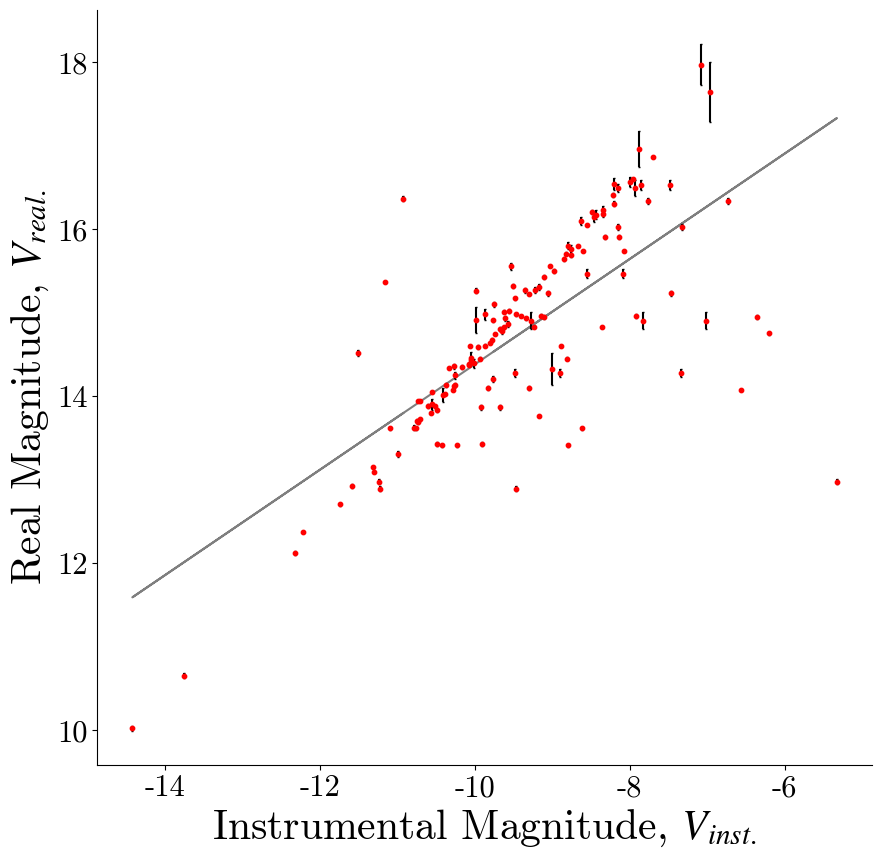

In [32]:
# --- fitting data for graph --- 
popt, pcov = curve_fit(lin_func, obs_mag, catalog_mag)#, sigma = (catalog_mag_err))
fit_data = lin_func(obs_mag, popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])

plt.plot(obs_mag, fit_data, 'k-', alpha = 0.5)
plt.scatter(obs_mag, catalog_mag, s = 10, color = 'red', zorder = 3)
plt.errorbar(obs_mag, catalog_mag, yerr=catalog_mag_err, ls = 'None', capsize = .5, color = 'black')
plt.xlabel('Instrumental Magnitude, $V_{{inst.}}$'); plt.ylabel('Real Magnitude, $V_{real.}$')

test_blobs = np.transpose([catalog_mag, obs_mag])
print(np.shape(test_blobs))

# Data Trimming 

/Library/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5241: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/Library/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Library/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:5319: RuntimeWarning: Degrees of freedom <= 0 for slice
  ddof=ddof, **kwargs)[()]
/Library/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Library/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


47 47
96 96


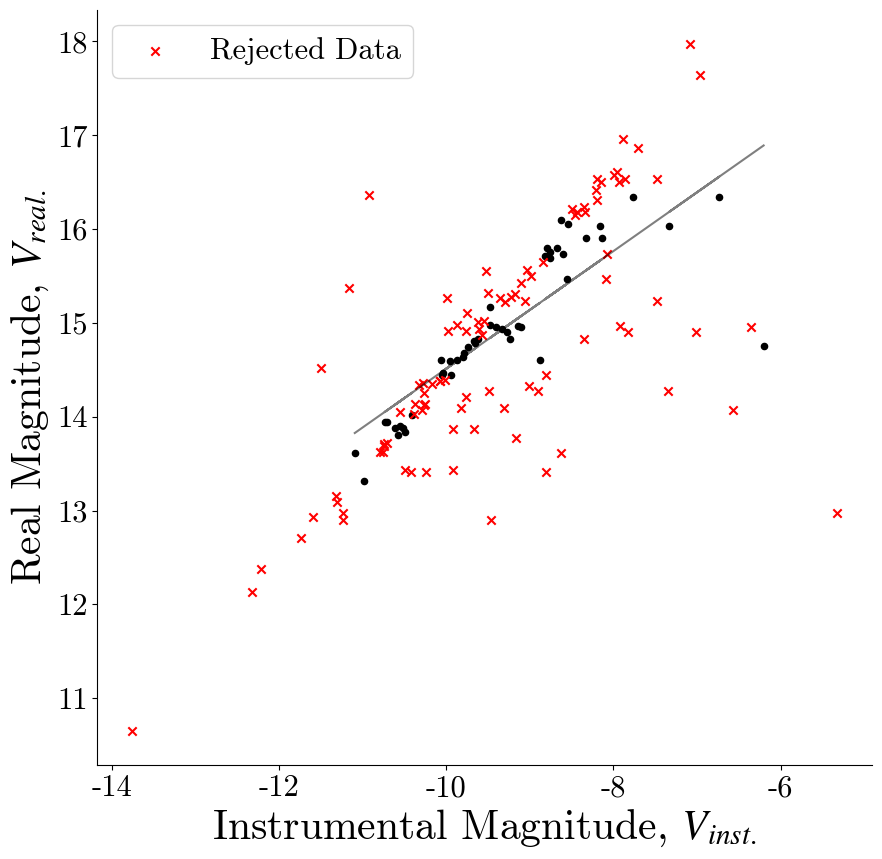

In [16]:
fake_data_x = obs_mag
fake_data_y = catalog_mag                         

limit = .5

num_bin_intervals = 10 # approx number of averaging windows
window_boundaries = np.linspace(min(fake_data_x),max(fake_data_x),int(len(fake_data_x)/num_bin_intervals)) # window boundaries
y_good = [] # list to collect the "well-behaved" y-axis data
x_good = [] # list to collect the "well-behaved" x-axis data
y_outlier = []
x_outlier = []

for i in range(len(window_boundaries)-1):

    # create a boolean mask to select the data within the averaging window
    window_indices = (fake_data_x<=window_boundaries[i+1]) & (fake_data_x>window_boundaries[i])
    # separate the pieces of data in the window
    fake_data_x_slice = fake_data_x[window_indices]
    fake_data_y_slice = fake_data_y[window_indices]

    # calculate the mean y_value in the window
    y_mean = np.mean(fake_data_y_slice)
    y_std = np.std(fake_data_y_slice)

    # choose and select the outliers
    y_outliers = fake_data_y_slice[np.abs(fake_data_y_slice-y_mean)>=limit*y_std]
    x_outliers = fake_data_x_slice[np.abs(fake_data_y_slice-y_mean)>=limit*y_std]

    # choose and select the good ones
    y_goodies = fake_data_y_slice[np.abs(fake_data_y_slice-y_mean)<limit*y_std]
    x_goodies = fake_data_x_slice[np.abs(fake_data_y_slice-y_mean)<limit*y_std]

    # extend the lists with all the good and the bad
    y_good.extend(list(y_goodies))
    y_outlier.extend(list(y_outliers))
    x_good.extend(list(x_goodies))
    x_outlier.extend(list(x_outliers))

print(len(y_good), len(x_good))
print(len(y_outlier), len(x_outlier))

# --- fitting data for graph --- 
popt, pcov = curve_fit(lin_func, x_good, y_good)#, sigma = (catalog_mag_err))
fit_data = lin_func(np.array(x_good), popt[0], popt[1])
slope_err = np.sqrt(pcov[0][0]); const_err = np.sqrt(pcov[1][1])

# --- Saving Fit Parameters ---    
data = {'params': popt, 'param_err': [slope_err, const_err]}  
df = pd.DataFrame(data)  
df.to_csv(r'calibration_parameters/' + target_name + '.txt', index=None, sep=' ', mode='a')

plt.scatter(x_good,y_good, color = 'black', s = 20)
plt.scatter(x_outlier,y_outlier, marker = 'x', color = 'red', label = 'Rejected Data')
# plt.errorbar(x_good, y_good, yerr=catalog_mag_err, ls = 'None', capsize = .5, color = 'black')

plt.plot(x_good, fit_data, 'k-', alpha = 0.5)
plt.xlabel('Instrumental Magnitude, $V_{{inst.}}$'); plt.ylabel('Real Magnitude, $V_{real.}$')
plt.legend()
plt.savefig('calibration_parameters/plots/' + target_name + '.png')

In [17]:
from sklearn.cluster import dbscan
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons

from queue import Queue

(144, 3)


/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass min_samples=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


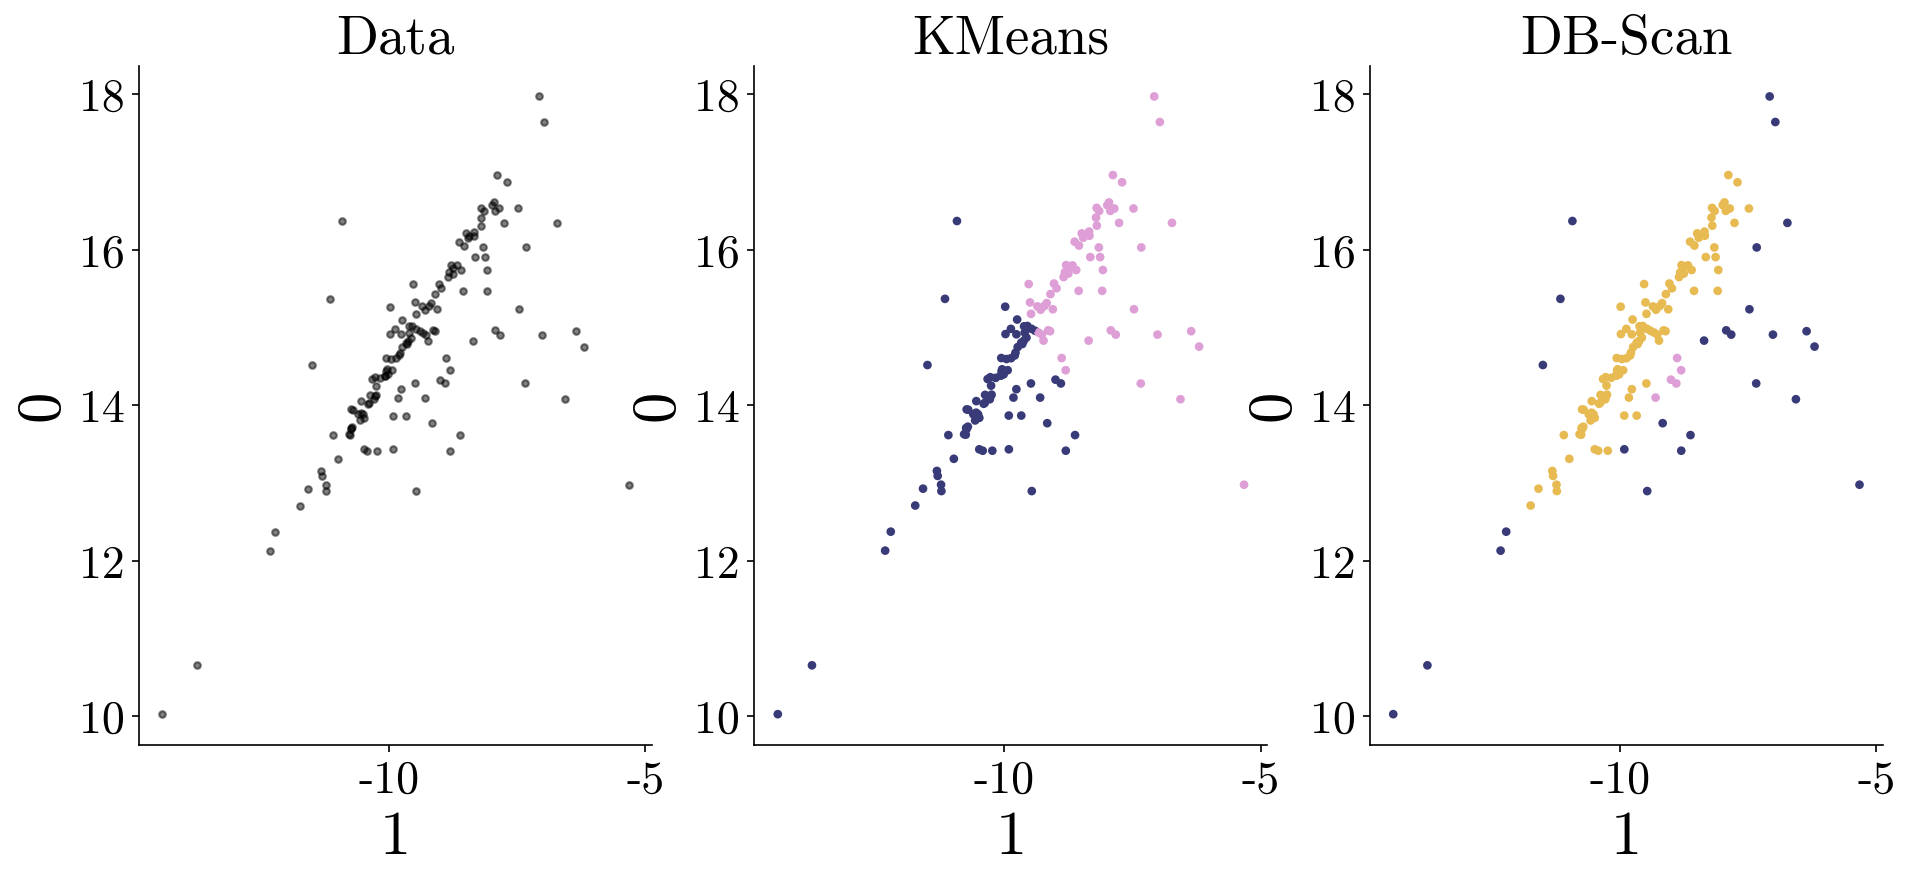

,0,1,2
139,15.018000,-9.553157,0.0
140,15.227000,-9.294708,0.0
141,16.572001,-7.993284,0.0
142,15.266000,-9.985449,0.0
143,16.368000,-10.926571,-1.0


In [73]:
# Create Blobs
blobs = make_moons(500, noise=0.055)[0]

# Standardized the data
for x in range(2):
    m = blobs[:,x].mean()
    s = blobs[:,x].std()
    for y in range(len(blobs)):
        blobs[y,x] = (blobs[y,x] - m)/s

# print(np.shape(blobs))
blobs = test_blobs

#Plot
# plt.style.use("bmh")
fig, ax = plt.subplots(1,3, dpi=150)
# fig.suptitle("DBSCAN Can Correctly Label Arbitrary Shaped Clusters", fontsize=20)

# Scikit-Learn KMeans
preds_k = KMeans(2).fit(blobs).labels_
kmean_blob = np.append(blobs, preds_k.reshape(-1,1), axis=1)
pd.DataFrame(kmean_blob).plot(x=1, y=0, kind="scatter",ax=ax[1], c=2, colorbar=False, colormap="tab20b", s = 10, title = 'KMeans')

# Scikit-Learn DBSCAN
preds = dbscan(blobs, .4, 5)[1]
dbscan_blob = np.append(blobs, preds.reshape(-1,1), axis=1)
print(np.shape(dbscan_blob))
pd.DataFrame(dbscan_blob).plot(x=1, y=0, kind="scatter", c=2, colorbar=False, ax=ax[2], title = 'DB-Scan', colormap="tab20b", s = 10)

# Test
pd.DataFrame(blobs).plot(x=1, y=0, kind="scatter", ax=ax[0], alpha=0.5, figsize=(15,6), title="Data", c="k", s = 10)

plt.show()

pd.DataFrame(dbscan_blob).tail()

In [74]:

print(pd.DataFrame(dbscan_blob).to_string())

             0          1    2
0    15.101000  -9.752311  0.0
1    15.557000  -9.527138  0.0
2    15.470000  -8.092295  0.0
3    15.470000  -8.552408  0.0
4    14.956000  -9.400876  0.0
5    14.380000 -10.075542  0.0
6    13.941000 -10.706672  0.0
7    16.537001  -8.201198  0.0
8    12.926000 -11.588679  0.0
9    12.709000 -11.740802  0.0
10   15.270000  -9.357102  0.0
11   10.026000 -14.422277 -1.0
12   14.593000  -9.959776  0.0
13   14.516000 -11.502565 -1.0
14   15.274000  -9.222156  0.0
15   14.911000  -9.766230  0.0
16   14.604000  -9.870353  0.0
17   14.359000 -10.275393  0.0
18   16.179001  -8.341901  0.0
19   14.868000  -9.570665  0.0
20   16.344000  -6.731695 -1.0
21   14.351000 -10.170801  0.0
22   16.344000  -7.763778  0.0
23   15.428000  -9.102516  0.0
24   15.761000  -8.753539  0.0
25   16.959000  -7.883853  0.0
26   12.129000 -12.327497 -1.0
27   12.373000 -12.218139 -1.0
28   12.895000 -11.230358  0.0
29   14.381000 -10.069137  0.0
30   15.321000  -9.501154  0.0
31   12.